In [85]:
import IPython
import pandas as pd
import matplotlib as ml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime

from IPython.display import Markdown as md
from IPython.display import Math as m

# Vital Signs Table

In [86]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")

# Content

## Automatic Chi2 Test

In [87]:
from scipy.stats import chi2_contingency
import IPython.display as display
from IPython.display import Markdown as md

def printmd(string):
    IPython.display.display(IPython.display.Markdown(string))

def printChi2Test(df,colName1,colName2,correction=True):
    dfCT = pd.crosstab(df[colName1],df[colName2])
    stat, p, dof, expected = chi2_contingency(dfCT,correction=correction)
    print(f"stat = {stat}")
    print(f"p = {p}")
    print(f"dof = {dof}")
    print(f"expected = {expected}")
    printmd(f"Since p={p:.1g}<0.05, based on Chi2 test we can reject hypothesis that death as outcome does not depend "
       f"on the presence of a renal disease.")

In [88]:
def printChi2(df,text="Empty",correction=True):
    printmd(f"# {text}")
    stat, p, dof, expected = chi2_contingency(df,correction=correction)
    print(f"stat = {stat}")
    print(f"p = {p}")
    print(f"dof = {dof}")
    print(f"expected = {expected}")
    printmd(f"Since p={p:.1g}<0.05, based on  test we can reject hypothesis that death as outcome does not depend "
   f"on the presence of a renal disease.")

In [89]:
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests
def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'

    return p_text

def chisq_and_posthoc_corrected(df):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")

    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
        chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")

In [90]:
%matplotlib inline

# Questions
- Are there differences in outcomes between people who present early (e.g. within 7 days of symptom onset) vs late?

# Data Reading
# Melted

In [91]:
fpMelted="C:\Work\dev\dECMT_src\data_all\COVID19_Data\Preprocessed_Data\df_melted_29092020_ow.csv"
fpMelted="C:\Work\dev\dECMT_src\data_all\COVID19_Data\Preprocessed_Data\df_melted_02102020_ow.csv"
dfMelted = pd.read_csv(fpMelted)

## Etnicity

In [92]:
fpEthinc = "C:\Work\dev\dECMT_src\data_all\COVID19_Data\Current\REACT_Demographics.csv"
# ethnicity
dfEthnic = pd.read_csv(fpEthinc)
dfEthnic.head()
dfEthnic.columns

Index(['STUDY_ID', 'PATIENT_AGE', 'DOB', 'DATE_OF_DEATH', 'DOD_DATE', 'GENDER',
       'ETHNIC_GROUP', 'SMOKING_HISTORY', 'POSTCODE', 'IS_PREGNANT', 'HEIG',
       'WEIG', 'BMI', 'FIRST_POS_DATE', 'FIRST_POS_DATE_R', 'FIRST_POS_TIME_R',
       'ADMIT_DATETIME', 'ADM_DATE_R', 'ADM_TIME_R', 'DISCHARGEDATE',
       'DISCHARGE_DATE_R', 'DISCHARGE_TIME_R', 'LOS', 'LOS_PREPOS', 'READM28',
       'READM_DATETIME', 'READM_DATE', 'READM_TIME'],
      dtype='object')

In [93]:
dfEthnicOnly = dfEthnic[['STUDY_ID','ETHNIC_GROUP']]

In [94]:
len(dfMelted)

264826

In [95]:
dfMelted = pd.merge(dfMelted,dfEthnicOnly,on='STUDY_ID',how='left')
len(dfMelted)

264826

In [96]:
selectedColsUnique = ['STUDY_ID','ADMISSION_START_DATE','ADMISSION_DAY_SINCE_ONSET', 'SYMPTOM_ONSET_DATE', 'ADMISSION_END_DATE','DEATH_DATE',
'DISCHARGE_DATE', 'DEATH', 'DISCHARGED','SURVIVED','READMITTED']

selectedCols = ['STUDY_ID','ADMISSION_START_DATE','ADMISSION_DAY_SINCE_ONSET',  'SYMPTOM_ONSET_DATE', 'ADMISSION_END_DATE','DEATH_DATE',
'DISCHARGE_DATE', 'DEATH', 'DISCHARGED','SURVIVED','ITU','NIV','READMITTED','PATIENT_AGE', 'GENDER','ASTHMA', 'COPD','BRONCHIECTASIS',
       'HYPERTENSION', 'THROMBOEMBOLIC', 'CARDIAC_D', 'RENAL_D', 'LIVER_D',
       'NEURAL_D', 'META_SOLID_TUMOUR', 'MAGLINANT_NEO', 'DIABETES', 'OBESITY',
       'HIV', 'RHEUMATO_D', 'DIMENTIA', 'IMMUNO', 'NB_COMOR','ETHNIC_GROUP','SPECIMEN_DATE', 'SPECIMEN_DAY_SINCE_ADMISSION', 'SPECIMENT_DAY_SINCE_ONSET',
       'PARAMETER', 'meanValue']

In [97]:
dfMeltedUnique = dfMelted.drop_duplicates(selectedColsUnique)[selectedCols]
dfMeltedUnique.head()

,STUDY_ID,ADMISSION_START_DATE,ADMISSION_DAY_SINCE_ONSET,SYMPTOM_ONSET_DATE,ADMISSION_END_DATE,DEATH_DATE,DISCHARGE_DATE,DEATH,DISCHARGED,SURVIVED,...,RHEUMATO_D,DIMENTIA,IMMUNO,NB_COMOR,ETHNIC_GROUP,SPECIMEN_DATE,SPECIMEN_DAY_SINCE_ADMISSION,SPECIMENT_DAY_SINCE_ONSET,PARAMETER,meanValue
0,UHSCOVID_00989a42,2020-03-26,5.0,2020-03-21,2020-04-02,NaN,2020-04-02,0.0,1.0,1.0,...,0.0,0.0,0.0,4.0,A,2020-03-26,0.0,5.0,ALT,NaN
8,UHSCOVID_00ac1e32,2020-04-07,-4.0,2020-04-11,2020-05-19,NaN,2020-05-19,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,A,2020-04-07,0.0,-4.0,ALT,NaN
51,UHSCOVID_00cb7bdd,2020-04-10,5.0,2020-04-05,2020-04-13,2020-04-13,2020-04-13,1.0,1.0,0.0,...,0.0,0.0,0.0,5.0,A,2020-04-10,0.0,5.0,ALT,25.0
54,UHSCOVID_01add35c,2020-05-22,0.0,2020-05-22,2020-05-23,2020-05-27,2020-05-23,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,A,2020-05-22,0.0,0.0,ALT,8.0
57,UHSCOVID_01f7838d,2020-05-04,-7.0,2020-05-11,2020-05-17,NaN,2020-05-17,0.0,1.0,1.0,...,0.0,0.0,0.0,5.0,A,2020-05-04,0.0,-7.0,ALT,9.0


In [98]:
dfMeltedUnique['NIV'].value_counts()

0.0    545
1.0    106
Name: NIV, dtype: int64

In [99]:
dfMeltedUnique['Death_Discharged_Survived_Str'] = pd.NA
dfMeltedUnique['Death_Discharged_Survived'] = pd.NA
map1= (dfMeltedUnique['DEATH']==0) & (dfMeltedUnique['DISCHARGED']==1) & (dfMeltedUnique['SURVIVED']==1)
dfMeltedUnique.loc[map1,'Death_Discharged_Survived']=0
dfMeltedUnique.loc[map1,'Death_Discharged_Survived_Str'] = 'Survived'

In [100]:
map2= (dfMeltedUnique['DEATH']==1) & (dfMeltedUnique['DISCHARGED']==0) & (dfMeltedUnique['SURVIVED']==0)
dfMeltedUnique.loc[map2,'Death_Discharged_Survived']=1
dfMeltedUnique.loc[map2,'Death_Discharged_Survived_Str'] = 'Died in Hospital'

In [101]:
dfMeltedUnique['Discharged_Readmitted_Died']="Missing" #"Unknown"
dfMeltedUnique.loc[(dfMeltedUnique['DISCHARGED']==1),'Discharged_Readmitted_Died']= "Discharged"
dfMeltedUnique.loc[(dfMeltedUnique['READMITTED']==1),'Discharged_Readmitted_Died']= "Readmitted"
dfMeltedUnique.loc[(dfMeltedUnique['DEATH']==1),'Discharged_Readmitted_Died']= "Died"

In [102]:
dfMeltedUnique['Died_in_Hosp_or_Discharged_or_Survived_Str']=pd.NA

In [103]:
# Died in Hospital, Died at Home, Survived

In [104]:
dfMeltedUnique['Died_or_Survived_Str']=pd.NA

In [105]:
dfMeltedUnique['Died_or_Survived'] = dfMeltedUnique['DEATH']

In [106]:
mapDied= dfMeltedUnique['DEATH']==1
dfMeltedUnique.loc[mapDied,'Died_or_Survived_Str']='Died'

In [107]:
mapSurvived = dfMeltedUnique['DEATH']==0
dfMeltedUnique.loc[mapSurvived,'Died_or_Survived_Str']='Survived'

In [108]:
cc = dfMeltedUnique['Died_or_Survived'].value_counts()
cc

0.0    435
1.0    216
Name: Died_or_Survived, dtype: int64

In [109]:
type(cc)

pandas.core.series.Series

In [110]:
# dictPresenterType3C = {'(-7,0] Early':0,'>7days Late':1,'<0 days (Hospital)':2}
dictPresenterType3C = {'Early Presenters':0,'Late Presenters':1,'Hospital Equired':2}
dictPresenterType3CReversed = {v:k for k,v in dictPresenterType3C.items()}
dictPresenterType3CReversed

{0: 'Early Presenters', 1: 'Late Presenters', 2: 'Hospital Equired'}

In [111]:
dfMeltedUnique['Onset Time']=pd.NA
dfMeltedUnique['Symptoms onset']='Unknown'

In [112]:
mp1= (dfMeltedUnique['ADMISSION_DAY_SINCE_ONSET']<=7) & (dfMeltedUnique['ADMISSION_DAY_SINCE_ONSET']>=0)
epS = 'Early Presenters'
epVal = dictPresenterType3C.get(epS)
dfMeltedUnique.loc[mp1,'Onset Time'] = epVal
dfMeltedUnique.loc[mp1,'Symptoms onset']= dictPresenterType3CReversed[epVal]

In [113]:
#{'Early Presenters':0,'Late Presenters':1,'Hospital Equired':2}

In [114]:
mp2= (dfMeltedUnique['ADMISSION_DAY_SINCE_ONSET']>7)
epS = 'Late Presenters'
epVal = dictPresenterType3C.get(epS)
dfMeltedUnique.loc[mp2,'Onset Time'] = epVal
dfMeltedUnique.loc[mp2,'Symptoms onset']= dictPresenterType3CReversed[epVal]

In [115]:
mp3= dfMeltedUnique['ADMISSION_DAY_SINCE_ONSET']<0
epS = 'Hospital Equired'
epVal = dictPresenterType3C.get(epS)
dfMeltedUnique.loc[mp3,'Onset Time'] = epVal
dfMeltedUnique.loc[mp3,'Symptoms onset']= dictPresenterType3CReversed[epVal]

# Died or Survived

In [116]:
# Groupping
dfMeltedUnique.columns

Index(['STUDY_ID', 'ADMISSION_START_DATE', 'ADMISSION_DAY_SINCE_ONSET',
       'SYMPTOM_ONSET_DATE', 'ADMISSION_END_DATE', 'DEATH_DATE',
       'DISCHARGE_DATE', 'DEATH', 'DISCHARGED', 'SURVIVED', 'ITU', 'NIV',
       'READMITTED', 'PATIENT_AGE', 'GENDER', 'ASTHMA', 'COPD',
       'BRONCHIECTASIS', 'HYPERTENSION', 'THROMBOEMBOLIC', 'CARDIAC_D',
       'RENAL_D', 'LIVER_D', 'NEURAL_D', 'META_SOLID_TUMOUR', 'MAGLINANT_NEO',
       'DIABETES', 'OBESITY', 'HIV', 'RHEUMATO_D', 'DIMENTIA', 'IMMUNO',
       'NB_COMOR', 'ETHNIC_GROUP', 'SPECIMEN_DATE',
       'SPECIMEN_DAY_SINCE_ADMISSION', 'SPECIMENT_DAY_SINCE_ONSET',
       'PARAMETER', 'meanValue', 'Death_Discharged_Survived_Str',
       'Death_Discharged_Survived', 'Discharged_Readmitted_Died',
       'Died_in_Hosp_or_Discharged_or_Survived_Str', 'Died_or_Survived_Str',
       'Died_or_Survived', 'Onset Time', 'Symptoms onset'],
      dtype='object')

In [117]:
# dfSel
# colSelected = ['STUDY_ID','ADMISSION_START_DATE','ETHNIC_GROUP', 'Symptoms onset', 'Died_or_Survived_Str','Discharged_Readmitted_Died','NIV',
#                'PATIENT_AGE', 'GENDER','ASTHMA', 'COPD','BRONCHIECTASIS',
#        'HYPERTENSION', 'THROMBOEMBOLIC', 'CARDIAC_D', 'RENAL_D', 'LIVER_D',
#        'NEURAL_D', 'META_SOLID_TUMOUR', 'MAGLINANT_NEO', 'DIABETES', 'OBESITY',
#        'HIV', 'RHEUMATO_D', 'DIMENTIA', 'IMMUNO', 'NB_COMOR','SPECIMEN_DATE', 'SPECIMEN_DAY_SINCE_ADMISSION', 'SPECIMENT_DAY_SINCE_ONSET',
#        'PARAMETER', 'meanValue']
# dfSel = dfMeltedUnique[colSelected]
dfSel = dfMeltedUnique
dfSel.head()

,STUDY_ID,ADMISSION_START_DATE,ADMISSION_DAY_SINCE_ONSET,SYMPTOM_ONSET_DATE,ADMISSION_END_DATE,DEATH_DATE,DISCHARGE_DATE,DEATH,DISCHARGED,SURVIVED,...,PARAMETER,meanValue,Death_Discharged_Survived_Str,Death_Discharged_Survived,Discharged_Readmitted_Died,Died_in_Hosp_or_Discharged_or_Survived_Str,Died_or_Survived_Str,Died_or_Survived,Onset Time,Symptoms onset
0,UHSCOVID_00989a42,2020-03-26,5.0,2020-03-21,2020-04-02,NaN,2020-04-02,0.0,1.0,1.0,...,ALT,NaN,Survived,0,Discharged,<NA>,Survived,0.0,0,Early Presenters
8,UHSCOVID_00ac1e32,2020-04-07,-4.0,2020-04-11,2020-05-19,NaN,2020-05-19,0.0,1.0,1.0,...,ALT,NaN,Survived,0,Discharged,<NA>,Survived,0.0,2,Hospital Equired
51,UHSCOVID_00cb7bdd,2020-04-10,5.0,2020-04-05,2020-04-13,2020-04-13,2020-04-13,1.0,1.0,0.0,...,ALT,25.0,<NA>,<NA>,Died,<NA>,Died,1.0,0,Early Presenters
54,UHSCOVID_01add35c,2020-05-22,0.0,2020-05-22,2020-05-23,2020-05-27,2020-05-23,1.0,1.0,0.0,...,ALT,8.0,<NA>,<NA>,Died,<NA>,Died,1.0,0,Early Presenters
57,UHSCOVID_01f7838d,2020-05-04,-7.0,2020-05-11,2020-05-17,NaN,2020-05-17,0.0,1.0,1.0,...,ALT,9.0,Survived,0,Discharged,<NA>,Survived,0.0,2,Hospital Equired


In [118]:
dfMelted[['STUDY_ID','SPECIMEN_DATE', 'SPECIMEN_DAY_SINCE_ADMISSION', 'SPECIMENT_DAY_SINCE_ONSET',
       'PARAMETER', 'meanValue']]

,STUDY_ID,SPECIMEN_DATE,SPECIMEN_DAY_SINCE_ADMISSION,SPECIMENT_DAY_SINCE_ONSET,PARAMETER,meanValue
0,UHSCOVID_00989a42,2020-03-26,0.0,5.0,ALT,NaN
1,UHSCOVID_00989a42,2020-03-27,1.0,6.0,ALT,NaN
2,UHSCOVID_00989a42,2020-03-28,2.0,7.0,ALT,NaN
3,UHSCOVID_00989a42,2020-03-29,3.0,8.0,ALT,23.0
4,UHSCOVID_00989a42,2020-03-30,4.0,9.0,ALT,NaN
...,...,...,...,...,...,...
264821,UHSCOVID_fe8c3d54,2020-04-13,11.0,4.0,Tidal Volume Expiratory,NaN
264822,UHSCOVID_fe8c3d54,2020-04-16,14.0,7.0,Tidal Volume Expiratory,NaN
264823,UHSCOVID_fe8c3d54,2020-04-18,16.0,9.0,Tidal Volume Expiratory,NaN
264824,UHSCOVID_ffd435ad,2020-03-31,-1.0,NaN,Tidal Volume Expiratory,NaN


In [119]:
dfMelted[['STUDY_ID','SPECIMEN_DATE', 'SPECIMEN_DAY_SINCE_ADMISSION', 'SPECIMENT_DAY_SINCE_ONSET',
       'PARAMETER', 'meanValue']].head()

,STUDY_ID,SPECIMEN_DATE,SPECIMEN_DAY_SINCE_ADMISSION,SPECIMENT_DAY_SINCE_ONSET,PARAMETER,meanValue
0,UHSCOVID_00989a42,2020-03-26,0.0,5.0,ALT,NaN
1,UHSCOVID_00989a42,2020-03-27,1.0,6.0,ALT,NaN
2,UHSCOVID_00989a42,2020-03-28,2.0,7.0,ALT,NaN
3,UHSCOVID_00989a42,2020-03-29,3.0,8.0,ALT,23.0
4,UHSCOVID_00989a42,2020-03-30,4.0,9.0,ALT,NaN


In [120]:
dfSel[['STUDY_ID','SPECIMEN_DATE', 'SPECIMEN_DAY_SINCE_ADMISSION', 'SPECIMENT_DAY_SINCE_ONSET',
       'PARAMETER', 'meanValue']].head()

,STUDY_ID,SPECIMEN_DATE,SPECIMEN_DAY_SINCE_ADMISSION,SPECIMENT_DAY_SINCE_ONSET,PARAMETER,meanValue
0,UHSCOVID_00989a42,2020-03-26,0.0,5.0,ALT,NaN
8,UHSCOVID_00ac1e32,2020-04-07,0.0,-4.0,ALT,NaN
51,UHSCOVID_00cb7bdd,2020-04-10,0.0,5.0,ALT,25.0
54,UHSCOVID_01add35c,2020-05-22,0.0,0.0,ALT,8.0
57,UHSCOVID_01f7838d,2020-05-04,0.0,-7.0,ALT,9.0


# Vital Signs

## Read Data

In [121]:
fpVital  = "C:\Work\dev\dECMT_src\data_all\COVID19_Data\Current\REACT_Vitalsigns_Numeric.csv"
dfVital = pd.read_csv(fpVital)

In [122]:
dfVital.head()

,STUDY_ID,DEPARTMENT,UNITFROM_DATETIME,UNITTO_DATETIME,PARAMETER,VALUE,RECORDED_DATETIME,RECORDED_DATE,RECORDED_TIME,VALIDATION_DATETIME
0,UHSCOVID_037e2bce,GICU,2020-04-14 20:54:00.000,2020-04-16 00:05:00.000,pO2_FiO2,32.066667,2020-04-14 15:40:00.000,14/04/2020,15:40:00,2020-04-14 22:39:00.000
1,UHSCOVID_037e2bce,GICU,2020-04-14 20:54:00.000,2020-04-16 00:05:00.000,pO2_FiO2,2.176471,2020-04-14 16:29:00.000,14/04/2020,16:29:00,2020-04-14 22:39:00.000
2,UHSCOVID_037e2bce,GICU,2020-04-14 20:54:00.000,2020-04-16 00:05:00.000,pO2_FiO2,25.666667,2020-04-14 22:32:00.000,14/04/2020,22:32:00,2020-04-14 22:39:00.000
3,UHSCOVID_037e2bce,GICU,2020-04-14 20:54:00.000,2020-04-16 00:05:00.000,pO2_FiO2,27.599998,2020-04-14 23:03:00.000,14/04/2020,23:03:00,2020-04-14 23:06:00.000
4,UHSCOVID_037e2bce,GICU,2020-04-14 20:54:00.000,2020-04-16 00:05:00.000,pO2_FiO2,34.750000,2020-04-15 00:04:00.000,15/04/2020,00:04:00,2020-04-15 00:35:00.000


In [123]:
dfVital.columns

Index(['STUDY_ID', 'DEPARTMENT', 'UNITFROM_DATETIME', 'UNITTO_DATETIME',
       'PARAMETER', 'VALUE', 'RECORDED_DATETIME', 'RECORDED_DATE',
       'RECORDED_TIME', 'VALIDATION_DATETIME'],
      dtype='object')

In [124]:
dfSel.shape

(651, 47)

In [125]:
dfMeltedUnique.shape

(651, 47)

# Vital Signs
# ADMISSION_START_DATE

In [126]:
# dateCols = ['ADMISSION_START_DATE','PATHOLOGY_SPECIMEN_DATE']
# dfLabAllSel[dateCols] = dfLabAllSel[dateCols].apply(pd.to_datetime)

In [127]:
# labName = 'ALT'
# # --------------------
# dfLabAllSel['Days_Lab_Since_Adm'] = (dfLabAllSel['PATHOLOGY_SPECIMEN_DATE'] - dfLabAllSel['ADMISSION_START_DATE'] ).dt.days
# dfLabAllSel['Days_Lab_Since_Adm'].value_counts()


In [128]:
# dfVital.columns
#
# ['STUDY_ID', 'DEPARTMENT', 'UNITFROM_DATETIME', 'UNITTO_DATETIME',
#        'PARAMETER', 'VALUE', 'RECORDED_DATETIME', 'RECORDED_DATE',
#        'RECORDED_TIME', 'VALIDATION_DATETIME']

In [129]:
selCols1 = ['STUDY_ID', 'ADMISSION_START_DATE','Symptoms onset']

In [130]:
dfVitalSAll = pd.merge(dfMeltedUnique[selCols1],dfVital,on='STUDY_ID',how='left')
dfVitalSAll.head()

,STUDY_ID,ADMISSION_START_DATE,Symptoms onset,DEPARTMENT,UNITFROM_DATETIME,UNITTO_DATETIME,PARAMETER,VALUE,RECORDED_DATETIME,RECORDED_DATE,RECORDED_TIME,VALIDATION_DATETIME
0,UHSCOVID_00989a42,2020-03-26,Early Presenters,G8,2020-03-26 20:22:00,2020-04-07 08:58:00,*Skin temperature,36.7,2020-04-02 07:36:00,02/04/2020,07:36:00,2020-04-02 07:36:00
1,UHSCOVID_00989a42,2020-03-26,Early Presenters,G8,2020-03-26 20:22:00,2020-04-07 08:58:00,*Respiration rate,18.0,2020-04-02 07:36:00,02/04/2020,07:36:00,2020-04-02 07:36:00
2,UHSCOVID_00989a42,2020-03-26,Early Presenters,G8,2020-03-26 20:22:00,2020-04-07 08:58:00,*Heart rate,95.0,2020-04-02 07:36:00,02/04/2020,07:36:00,2020-04-02 07:36:00
3,UHSCOVID_00989a42,2020-03-26,Early Presenters,G8,2020-03-26 20:22:00,2020-04-07 08:58:00,*Non-invasive systolic blood pressure,128.0,2020-04-02 07:36:00,02/04/2020,07:36:00,2020-04-02 07:36:00
4,UHSCOVID_00989a42,2020-03-26,Early Presenters,G8,2020-03-26 20:22:00,2020-04-07 08:58:00,*Non-invasive diastolic blood pressure,75.0,2020-04-02 07:36:00,02/04/2020,07:36:00,2020-04-02 07:36:00


In [131]:
dfVitalSAll = dfVitalSAll[dfVitalSAll['PARAMETER'].notna()]

In [132]:
dfVitalSAll['PARAMETER'].unique()

array(['*Skin temperature', '*Respiration rate', '*Heart rate',
       '*Non-invasive systolic blood pressure',
       '*Non-invasive diastolic blood pressure', 'pO2_FiO2',
       'Tidal Volume Expiratory', '*Diastolic blood pressure',
       '*Systolic blood pressure', 'ABL835_pO2', 'ABL835_FiO2',
       'Positive End Expiratory Pressure', '*Core temperature'],
      dtype=object)

In [133]:
dfVitalSAll['PARAMETER'].value_counts()

*Heart rate                               73158
*Respiration rate                         72754
*Skin temperature                         46386
*Non-invasive systolic blood pressure     45225
*Non-invasive diastolic blood pressure    45194
Tidal Volume Expiratory                   31216
*Diastolic blood pressure                 29867
*Systolic blood pressure                  29860
Positive End Expiratory Pressure          24129
ABL835_pO2                                14332
ABL835_FiO2                               14217
pO2_FiO2                                  12742
*Core temperature                          3503
Name: PARAMETER, dtype: int64

In [134]:
dfVitalSAll.columns

Index(['STUDY_ID', 'ADMISSION_START_DATE', 'Symptoms onset', 'DEPARTMENT',
       'UNITFROM_DATETIME', 'UNITTO_DATETIME', 'PARAMETER', 'VALUE',
       'RECORDED_DATETIME', 'RECORDED_DATE', 'RECORDED_TIME',
       'VALIDATION_DATETIME'],
      dtype='object')

In [135]:
# ['STUDY_ID', 'ADMISSION_START_DATE', 'Symptoms onset', 'DEPARTMENT',
#        'UNITFROM_DATETIME', 'UNITTO_DATETIME', 'PARAMETER', 'VALUE',
#        'RECORDED_DATETIME', 'RECORDED_DATE', 'RECORDED_TIME',
#        'VALIDATION_DATETIME'],

dateCols = ['ADMISSION_START_DATE', 'RECORDED_DATETIME']
dfVitalSAll[dateCols] = dfVitalSAll[dateCols].apply(pd.to_datetime)

In [136]:
dfVitalSAll['Vital_Signs_Since_Adm'] = (dfVitalSAll['RECORDED_DATETIME'] -
                                     dfVitalSAll['ADMISSION_START_DATE'] ).dt.days
dfVitalSAll['Vital_Signs_Since_Adm'].value_counts()

1      25979
2      25308
3      24268
4      22319
5      20622
       ...  
148       15
143       15
140       15
139       15
174        5
Name: Vital_Signs_Since_Adm, Length: 175, dtype: int64

In [137]:
dfVitalSAll.columns

Index(['STUDY_ID', 'ADMISSION_START_DATE', 'Symptoms onset', 'DEPARTMENT',
       'UNITFROM_DATETIME', 'UNITTO_DATETIME', 'PARAMETER', 'VALUE',
       'RECORDED_DATETIME', 'RECORDED_DATE', 'RECORDED_TIME',
       'VALIDATION_DATETIME', 'Vital_Signs_Since_Adm'],
      dtype='object')

In [138]:
colsVitalSel =  ['STUDY_ID',  'Symptoms onset',  'PARAMETER', 'VALUE','Vital_Signs_Since_Adm', 'UNITFROM_DATETIME']
dfVitalSAll = dfVitalSAll[colsVitalSel]
dfVitalSAll.head()

,STUDY_ID,Symptoms onset,PARAMETER,VALUE,Vital_Signs_Since_Adm,UNITFROM_DATETIME
0,UHSCOVID_00989a42,Early Presenters,*Skin temperature,36.7,7,2020-03-26 20:22:00
1,UHSCOVID_00989a42,Early Presenters,*Respiration rate,18.0,7,2020-03-26 20:22:00
2,UHSCOVID_00989a42,Early Presenters,*Heart rate,95.0,7,2020-03-26 20:22:00
3,UHSCOVID_00989a42,Early Presenters,*Non-invasive systolic blood pressure,128.0,7,2020-03-26 20:22:00
4,UHSCOVID_00989a42,Early Presenters,*Non-invasive diastolic blood pressure,75.0,7,2020-03-26 20:22:00


In [139]:
def is_nan(x):
    return (x is np.nan or x != x or len(str(x))<1)

In [140]:
print(is_nan(0.2))
print(is_nan(""))

False
True


In [141]:
vitalParamsLst = dfVitalSAll['PARAMETER'].unique()
vitalParamsLst

array(['*Skin temperature', '*Respiration rate', '*Heart rate',
       '*Non-invasive systolic blood pressure',
       '*Non-invasive diastolic blood pressure', 'pO2_FiO2',
       'Tidal Volume Expiratory', '*Diastolic blood pressure',
       '*Systolic blood pressure', 'ABL835_pO2', 'ABL835_FiO2',
       'Positive End Expiratory Pressure', '*Core temperature'],
      dtype=object)

In [142]:
print(np.nan)

nan


In [143]:
vitalParamsLst = [x for x in vitalParamsLst if not is_nan(x)]
vitalParamsLst

['*Skin temperature',
 '*Respiration rate',
 '*Heart rate',
 '*Non-invasive systolic blood pressure',
 '*Non-invasive diastolic blood pressure',
 'pO2_FiO2',
 'Tidal Volume Expiratory',
 '*Diastolic blood pressure',
 '*Systolic blood pressure',
 'ABL835_pO2',
 'ABL835_FiO2',
 'Positive End Expiratory Pressure',
 '*Core temperature']

In [144]:
dfVitalSAll['PARAMETER'].value_counts()

*Heart rate                               73158
*Respiration rate                         72754
*Skin temperature                         46386
*Non-invasive systolic blood pressure     45225
*Non-invasive diastolic blood pressure    45194
Tidal Volume Expiratory                   31216
*Diastolic blood pressure                 29867
*Systolic blood pressure                  29860
Positive End Expiratory Pressure          24129
ABL835_pO2                                14332
ABL835_FiO2                               14217
pO2_FiO2                                  12742
*Core temperature                          3503
Name: PARAMETER, dtype: int64

In [145]:
vitalParamName = '*Heart rate'

In [146]:
dfVitalSWoHospitalUnknown =  dfVitalSAll.drop(dfVitalSAll[(dfVitalSAll['Symptoms onset']=="Unknown") |
                                                       (dfVitalSAll['Symptoms onset']== "Hospital Equired") ].index)

#### Single - Table Live Signs

In [147]:
dfVitalSWoHospitalUnknownUnique = dfVitalSWoHospitalUnknown.drop_duplicates('STUDY_ID',keep='last')
dfVitalSWoHospitalUnknownUnique

,STUDY_ID,Symptoms onset,PARAMETER,VALUE,Vital_Signs_Since_Adm,UNITFROM_DATETIME
144,UHSCOVID_00989a42,Early Presenters,*Skin temperature,36.4,1,2020-03-26 20:22:00
1447,UHSCOVID_00cb7bdd,Early Presenters,*Skin temperature,36.6,1,2020-04-11 00:55:00
1477,UHSCOVID_01add35c,Early Presenters,*Skin temperature,36.5,0,2020-05-22 10:17:00
2219,UHSCOVID_025d562e,Early Presenters,*Non-invasive systolic blood pressure,114.0,1,2020-05-01 23:43:00
2687,UHSCOVID_037e2bce,Early Presenters,ABL835_FiO2,30.0,0,2020-04-14 20:54:00
...,...,...,...,...,...,...
434952,UHSCOVID_fb8446a4,Early Presenters,*Non-invasive systolic blood pressure,117.0,0,2020-04-14 19:13:00
441498,UHSCOVID_fc872d82,Late Presenters,ABL835_FiO2,75.0,0,2020-03-24 23:18:00
441598,UHSCOVID_fd016c0e,Late Presenters,*Heart rate,73.0,0,2020-04-11 13:22:00
441724,UHSCOVID_fd4da220,Early Presenters,*Respiration rate,22.0,0,2020-04-14 16:08:00


In [148]:
dfVitalSWoHospitalUnknownUnique.groupby(['Symptoms onset']).count()#agg(Count_Vital_Lab=('','count')

,STUDY_ID,PARAMETER,VALUE,Vital_Signs_Since_Adm,UNITFROM_DATETIME
Symptoms onset,,,,,
Early Presenters,323,323,323,323,323
Late Presenters,103,103,103,103,103


In [149]:
outTable = pd.DataFrame(columns=['PARAMETER','LATE','EARLY'])

In [150]:
vitalParamName
mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
# mean = dfAlt["VALUE"].mean()
# stdV = dfAlt["VALUE"].std()
grp2 = dfAlt.groupby('Symptoms onset').agg(Mean_Lab = ('VALUE','mean'),Std_Lab = ('VALUE','std'))
# ------------------------------------------------
lpMean = grp2.loc['Late Presenters','Mean_Lab']
lpStd = grp2.loc['Late Presenters','Std_Lab']
# ------------------------------------------------
epMean = grp2.loc['Early Presenters','Mean_Lab']
epStd = grp2.loc['Early Presenters','Std_Lab']
# ------------------------------------------------
outTable = outTable.append({'PARAMETER': f"{vitalParamName}",'LATE':f"{lpMean:0.0f} ({lpStd:0.0f})",
                                    'EARLY':f"{epMean:0.0f} ({epStd:0.0f})"}, ignore_index=True)
print("====================================================")
print(vitalParamName)
print(grp2)
print("====================================================")
print(dfAlt['UNITFROM_DATETIME'].iloc[0])
print("====================================================")
# sns.boxplot(data=dfAlt, y='Symptoms onset',x="VALUE")
# plt.xlabel(f"{vitalParamName}  - Vital Signs")
# plt.show()
outTable.head()

*Heart rate
                   Mean_Lab    Std_Lab
Symptoms onset                        
Early Presenters  86.441265  17.138806
Late Presenters   85.504216  16.038267
2020-03-26 20:22:00


,PARAMETER,LATE,EARLY
0,*Heart rate,86 (16),86 (17)


In [151]:
dfAlt.head()

,STUDY_ID,Symptoms onset,PARAMETER,VALUE,Vital_Signs_Since_Adm,UNITFROM_DATETIME
2,UHSCOVID_00989a42,Early Presenters,*Heart rate,95.0,7,2020-03-26 20:22:00
8,UHSCOVID_00989a42,Early Presenters,*Heart rate,90.0,6,2020-03-26 20:22:00
12,UHSCOVID_00989a42,Early Presenters,*Heart rate,107.0,6,2020-03-26 20:22:00
17,UHSCOVID_00989a42,Early Presenters,*Heart rate,88.0,6,2020-03-26 20:22:00
20,UHSCOVID_00989a42,Early Presenters,*Heart rate,99.0,6,2020-03-26 20:22:00


In [152]:
grp3 = dfAlt.groupby('Symptoms onset')['VALUE']
grp3

[Text(0.5, 0, 'Bernoulli'), Text(0, 0.5, 'Frequency')]

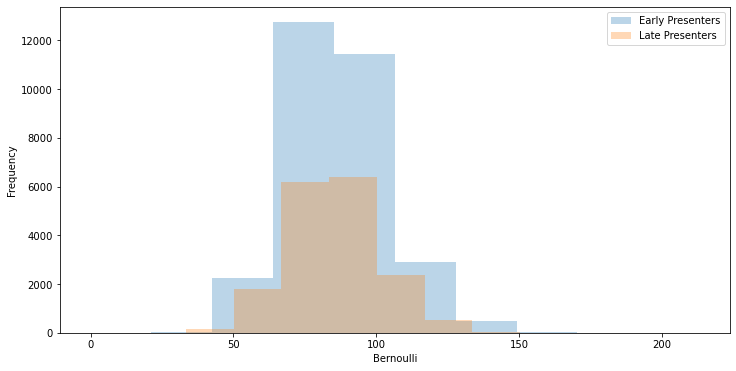

In [153]:
fig, ax = grp3.plot(kind='hist', figsize=[12,6], alpha=.3, legend=True)
ax.set(xlabel='Bernoulli', ylabel='Frequency')

[Text(0.5, 0, 'Bernoulli'), Text(0, 0.5, 'Frequency')]

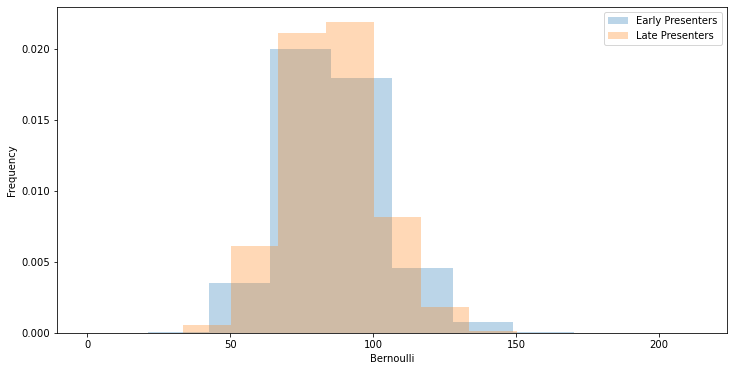

In [154]:
fig, ax = grp3.plot(kind='hist', figsize=[12,6], alpha=.3, legend=True,density=True)
ax.set(xlabel='Bernoulli', ylabel='Frequency')

#### Loop - Table Live Signs

In [155]:
# Rounded to whole numbers
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
outTable = pd.DataFrame(columns=['PARAMETER','LATE','EARLY'])
print("====================================================")
for vitalParamName in vitalParamsLst:
    # print(vitalParamName)
    # print(vitalParamName)
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    # print(f"--- {vitalParamName} -----------------------")
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    print(dfAlt.head())
    # print(f"----------------------------------------------")
    # print(dfAlt.head())
    # print(f"----------------------------------------------")
    # mean = dfAlt["VALUE"].mean()
    # stdV = dfAlt["VALUE"].std()
    grp2 = dfAlt.groupby('Symptoms onset').agg(Mean_Lab = ('VALUE','mean'),Std_Lab = ('VALUE','std'))
    # print(f"----- grp2 ---------------------------------------")
    # print(vitalParamName)
    # print(grp2)
    # print(f"----------------------------------------------")
    # ------------------------------------------------
    lpMean = grp2.loc['Late Presenters','Mean_Lab']
    lpStd = grp2.loc['Late Presenters','Std_Lab']
    # ------------------------------------------------
    epMean = grp2.loc['Early Presenters','Mean_Lab']
    epStd = grp2.loc['Early Presenters','Std_Lab']
    # ------------------------------------------------
    outTable = outTable.append({'PARAMETER': f"{vitalParamName}, mean (SD)",'LATE':f"{lpMean:0.0f} ({lpStd:0.0f})",
                                        'EARLY':f"{epMean:0.0f} ({epStd:0.0f})"}, ignore_index=True)
print("--- outTable ---------------------------------")
print(outTable)
dirOut = "C:\Work\DropBoxPS\Dropbox\dev\data\dECMT\COVID19_SH\Outputs_covid\Manuscript Covid 20_10"
fnOut = f"vital_signs_mean_std_Table_{timeStampStr}.csv"
p = Path(dirOut)
p.mkdir(parents=True, exist_ok=True)
fpOut = p / fnOut
outTable.to_csv(fpOut,index=False)
print("====================================================")


             STUDY_ID    Symptoms onset          PARAMETER  VALUE  \
0   UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.7   
7   UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.4   
13  UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.8   
19  UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.9   
22  UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.8   

    Vital_Signs_Since_Adm    UNITFROM_DATETIME  
0                       7  2020-03-26 20:22:00  
7                       6  2020-03-26 20:22:00  
13                      6  2020-03-26 20:22:00  
19                      6  2020-03-26 20:22:00  
22                      6  2020-03-26 20:22:00  
             STUDY_ID    Symptoms onset          PARAMETER  VALUE  \
1   UHSCOVID_00989a42  Early Presenters  *Respiration rate   18.0   
6   UHSCOVID_00989a42  Early Presenters  *Respiration rate   17.0   
14  UHSCOVID_00989a42  Early Presenters  *Respiration rate   21.0   
15  UHSCOVID_00

In [156]:
# Decimal whole numbers
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
outTable = pd.DataFrame(columns=['PARAMETER','LATE','EARLY'])
print("====================================================")
for vitalParamName in vitalParamsLst:
    # print(vitalParamName)
    # print(vitalParamName)
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    # print(f"--- {vitalParamName} -----------------------")
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    print(dfAlt.head())
    # print(f"----------------------------------------------")
    # print(dfAlt.head())
    # print(f"----------------------------------------------")
    # mean = dfAlt["VALUE"].mean()
    # stdV = dfAlt["VALUE"].std()
    grp2 = dfAlt.groupby('Symptoms onset').agg(Mean_Lab = ('VALUE','mean'),Std_Lab = ('VALUE','std'))
    # print(f"----- grp2 ---------------------------------------")
    # print(vitalParamName)
    # print(grp2)
    # print(f"----------------------------------------------")
    # ------------------------------------------------
    lpMean = grp2.loc['Late Presenters','Mean_Lab']
    lpStd = grp2.loc['Late Presenters','Std_Lab']
    # ------------------------------------------------
    epMean = grp2.loc['Early Presenters','Mean_Lab']
    epStd = grp2.loc['Early Presenters','Std_Lab']
    # ------------------------------------------------
    outTable = outTable.append({'PARAMETER': f"{vitalParamName}, mean (SD)",'LATE':f"{lpMean:0.1f} ({lpStd:0.1f})",
                                        'EARLY':f"{epMean:0.1f} ({epStd:0.1f})"}, ignore_index=True)
print("--- outTable ---------------------------------")
print(outTable)
dirOut = "C:\Work\DropBoxPS\Dropbox\dev\data\dECMT\COVID19_SH\Outputs_covid\Manuscript Covid 20_10"
fnOut = f"vital_signs_mean_std_Table_decimal_{timeStampStr}.csv"
p = Path(dirOut)
p.mkdir(parents=True, exist_ok=True)
fpOut = p / fnOut
outTable.to_csv(fpOut,index=False)
print("====================================================")

             STUDY_ID    Symptoms onset          PARAMETER  VALUE  \
0   UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.7   
7   UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.4   
13  UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.8   
19  UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.9   
22  UHSCOVID_00989a42  Early Presenters  *Skin temperature   36.8   

    Vital_Signs_Since_Adm    UNITFROM_DATETIME  
0                       7  2020-03-26 20:22:00  
7                       6  2020-03-26 20:22:00  
13                      6  2020-03-26 20:22:00  
19                      6  2020-03-26 20:22:00  
22                      6  2020-03-26 20:22:00  
             STUDY_ID    Symptoms onset          PARAMETER  VALUE  \
1   UHSCOVID_00989a42  Early Presenters  *Respiration rate   18.0   
6   UHSCOVID_00989a42  Early Presenters  *Respiration rate   17.0   
14  UHSCOVID_00989a42  Early Presenters  *Respiration rate   21.0   
15  UHSCOVID_00

#### Single - Boxplots Live Signs

In [157]:
vitalParamName
mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
dfAlt = dfVitalSWoHospitalUnknown[mapLabR]

*Core temperature
2020-04-26 14:54:00.000


C:\ANACONDA3\envs\dECMT\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 70.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ANACONDA3\envs\dECMT\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 63.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 6.79999999999999, '*Core temperature  - Vital Signs')

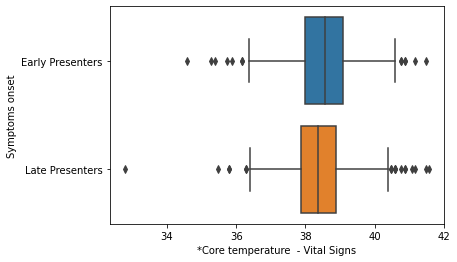

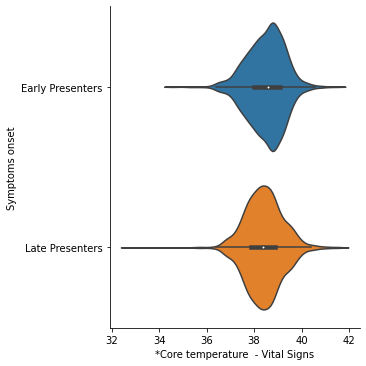

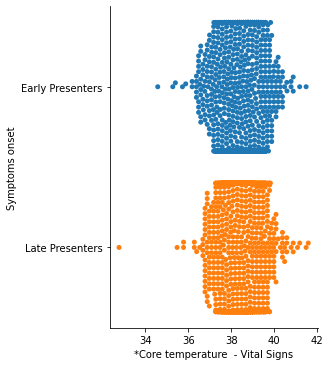

In [158]:
print("====================================================")
print(vitalParamName)
print("====================================================")
print(dfAlt['UNITFROM_DATETIME'].iloc[0])
print("====================================================")
sns.boxplot(data=dfAlt, y='Symptoms onset',x="VALUE")
plt.xlabel(f"{vitalParamName}  - Vital Signs")
sns.catplot(y='Symptoms onset',x="VALUE",  kind = "violin", split = True,data=dfAlt)
plt.xlabel(f"{vitalParamName}  - Vital Signs")
sns.catplot(y='Symptoms onset',x="VALUE", aspect=.9,kind="swarm", data=dfAlt)
plt.xlabel(f"{vitalParamName}  - Vital Signs")

In [159]:
dfAlt.columns

Index(['STUDY_ID', 'Symptoms onset', 'PARAMETER', 'VALUE',
       'Vital_Signs_Since_Adm', 'UNITFROM_DATETIME'],
      dtype='object')

In [160]:
# sns.distplot(dfAlt, x="VALUE")
# plt.xlabel(f"{vitalParamName}  - Vital Signs")
# plt.show()

In [161]:
# sns.distplot(dfAlt, x="VALUE", hue='Symptoms onset', element="step")
# plt.show()

#### Loop - Boxplots Live Signs

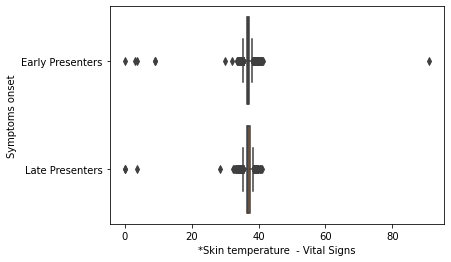

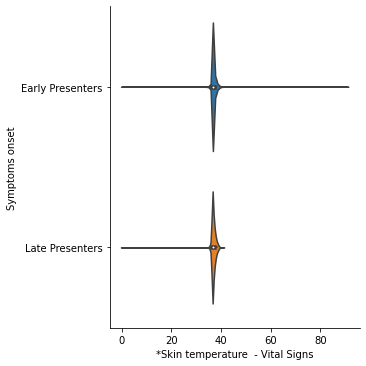

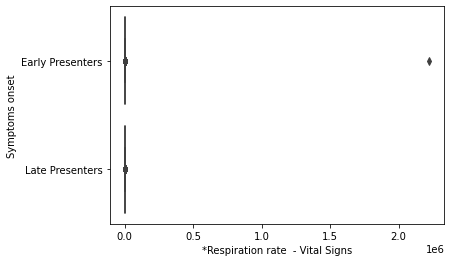

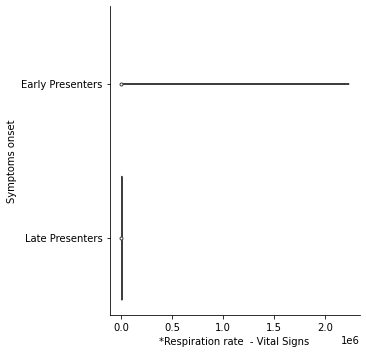

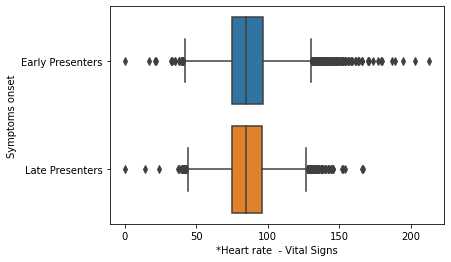

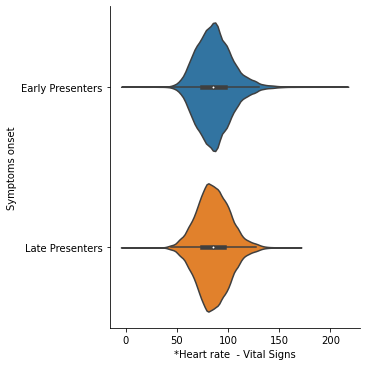

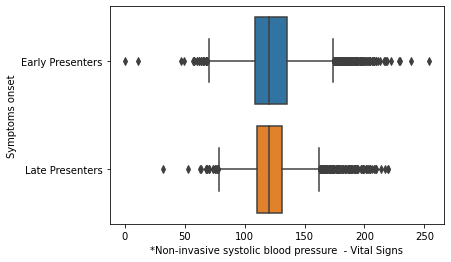

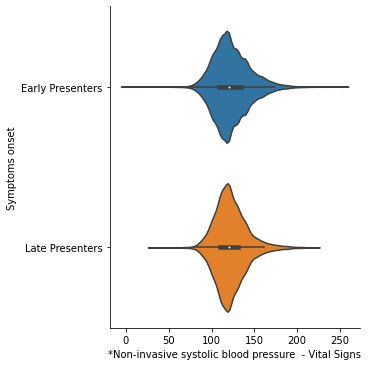

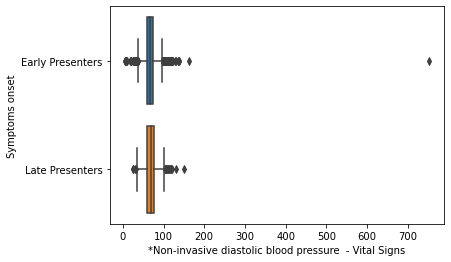

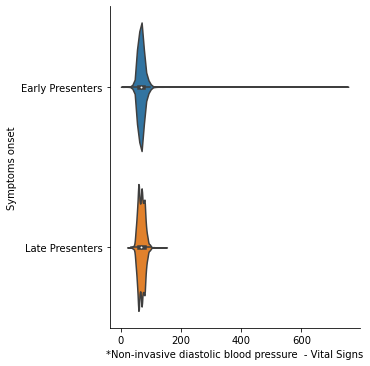

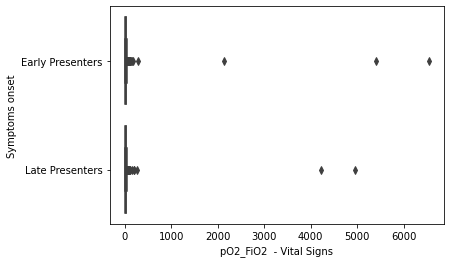

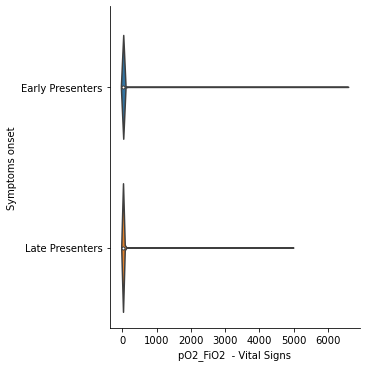

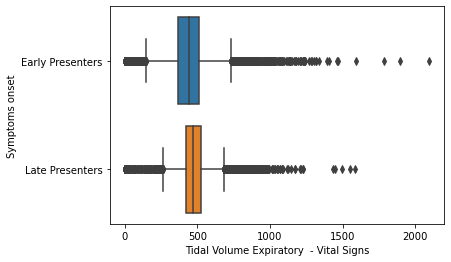

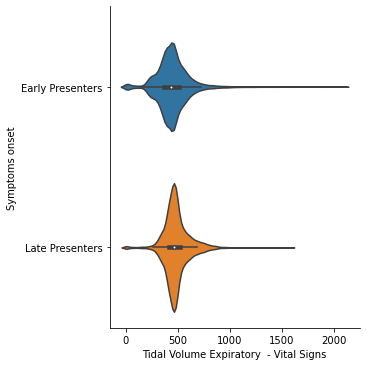

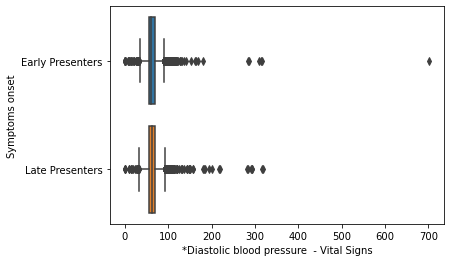

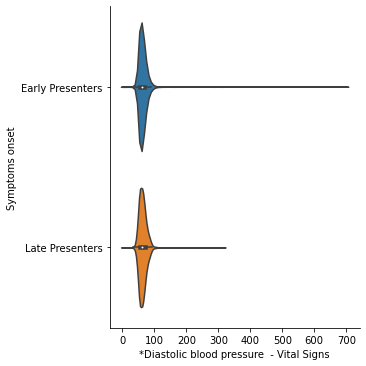

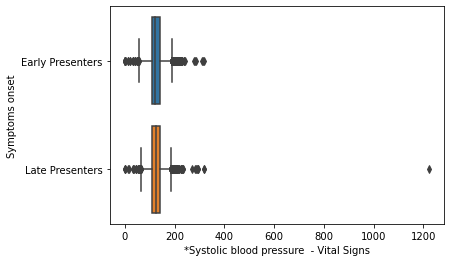

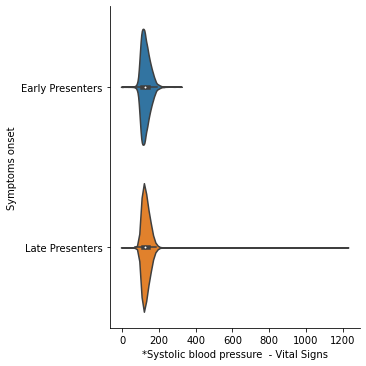

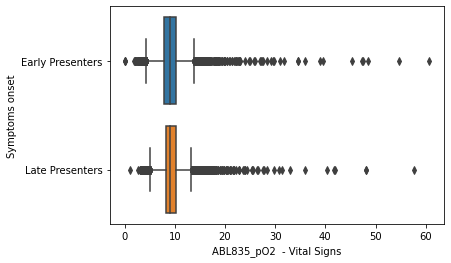

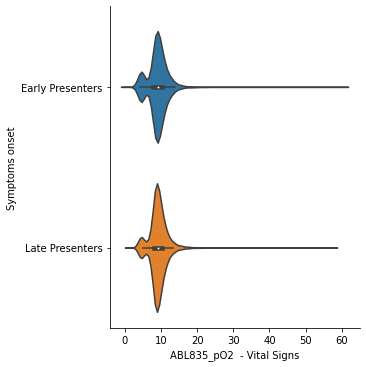

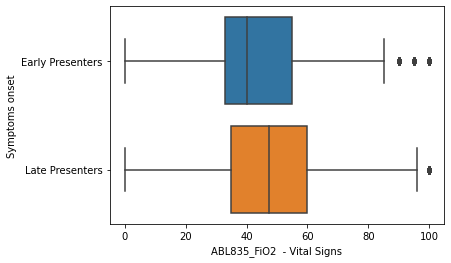

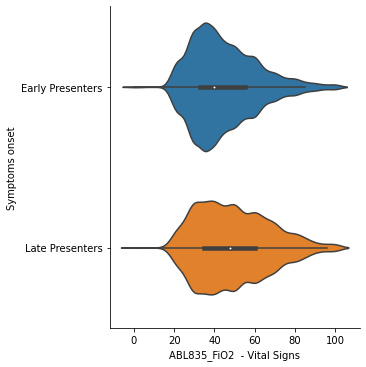

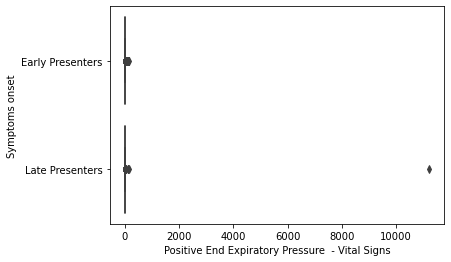

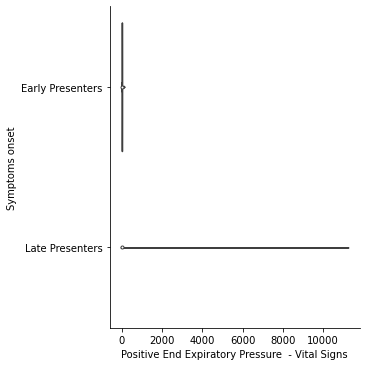

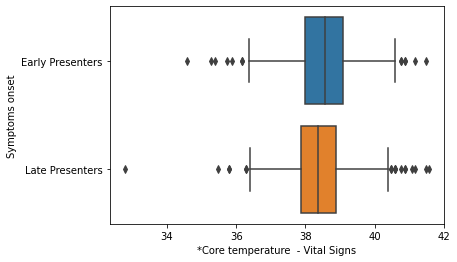

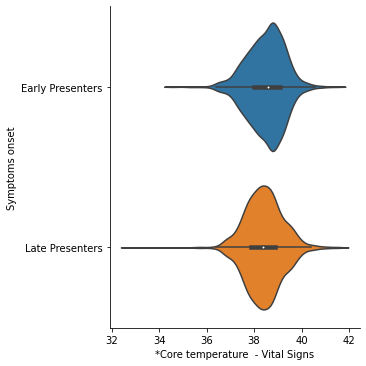

In [162]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
# vitalParamName
# vitalParamsLst = ['*Heart rate']
print("====================================================")
for vitalParamName in vitalParamsLst:
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    # print("====================================================")
    # print(vitalParamName)
    # print("====================================================")
    # print(dfAlt['UNITFROM_DATETIME'].iloc[0])
    sns.boxplot(data=dfAlt, y='Symptoms onset',x="VALUE")
    plt.xlabel(f"{vitalParamName}  - Vital Signs")
    plt.show()
    # print("------------------------------------------------------")
    sns.catplot(y='Symptoms onset',x="VALUE",  kind = "violin", split = True,data=dfAlt)
    plt.xlabel(f"{vitalParamName}  - Vital Signs")
    plt.show()
    # sns.catplot(y='Symptoms onset',x="VALUE", aspect=.9,kind="swarm", data=dfAlt)
    # plt.xlabel(f"{vitalParamName}  - Vital Signs")
    # plt.show()
    # sns.distplot(dfAlt, x="VALUE", hue='Symptoms onset', element="step")
    #

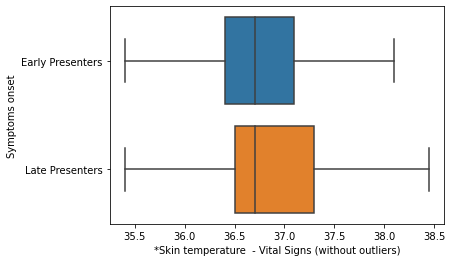

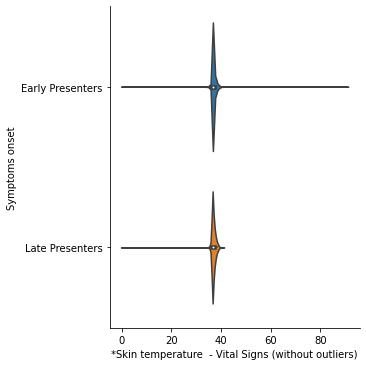

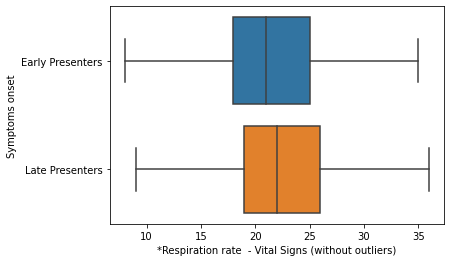

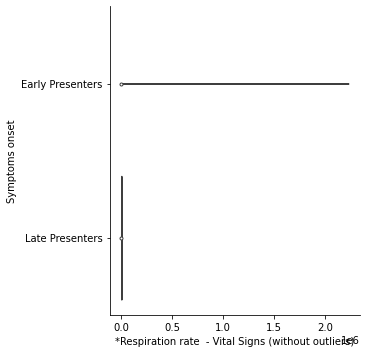

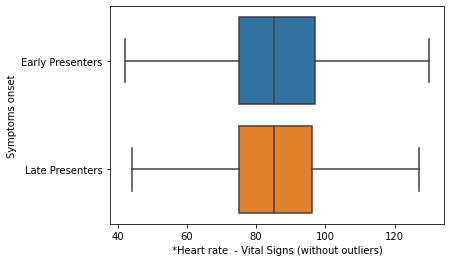

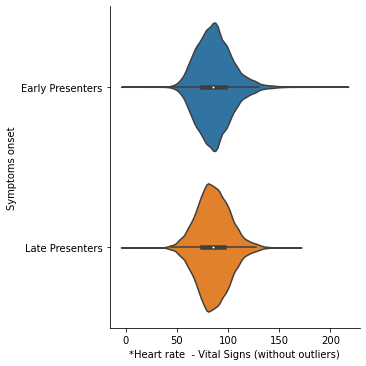

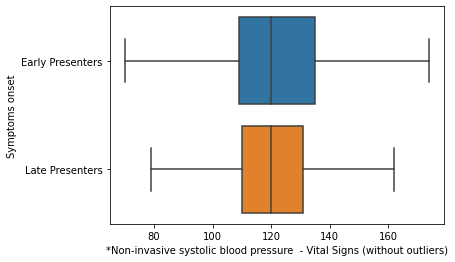

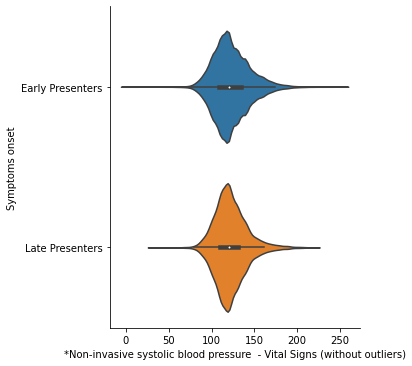

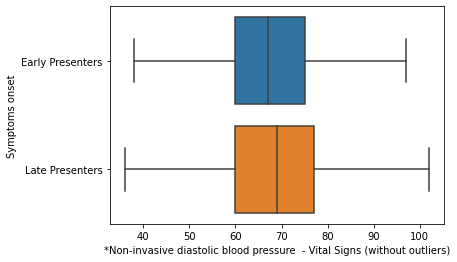

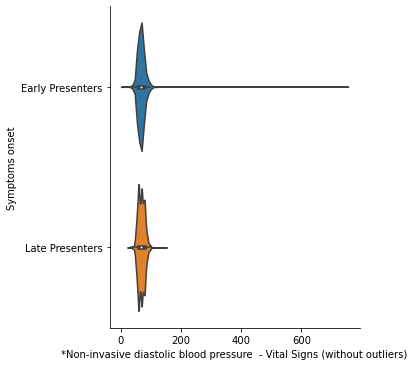

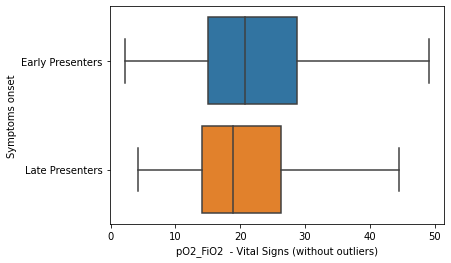

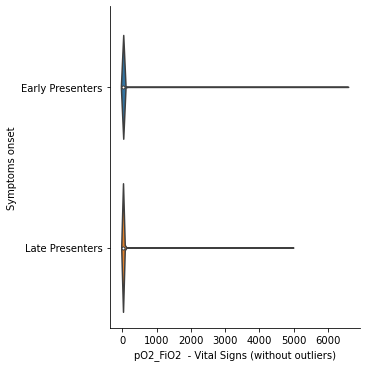

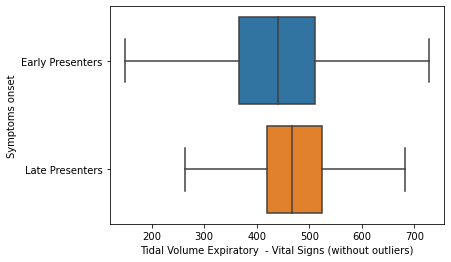

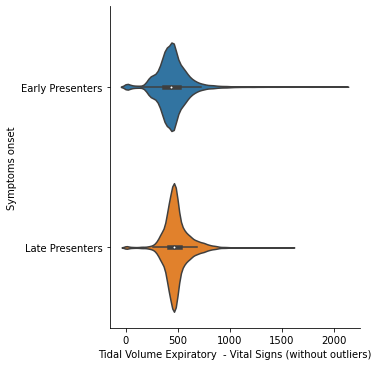

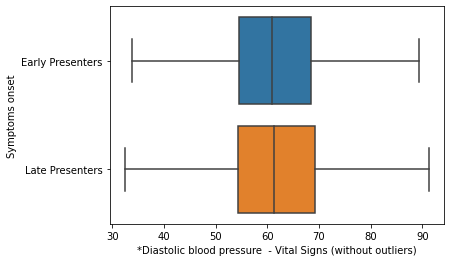

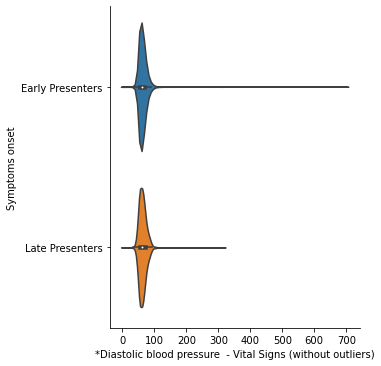

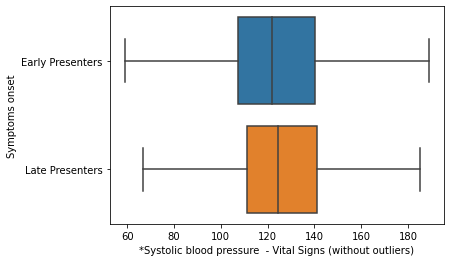

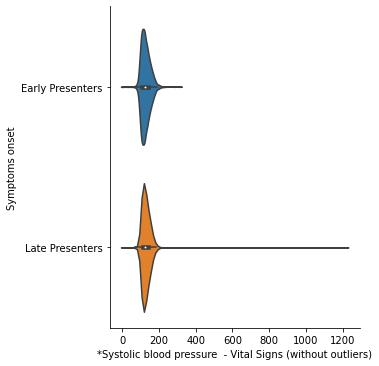

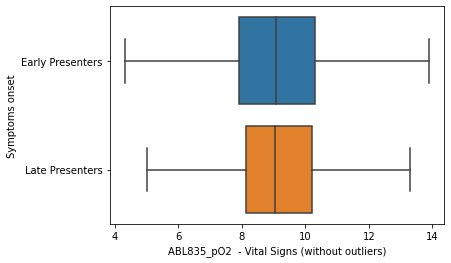

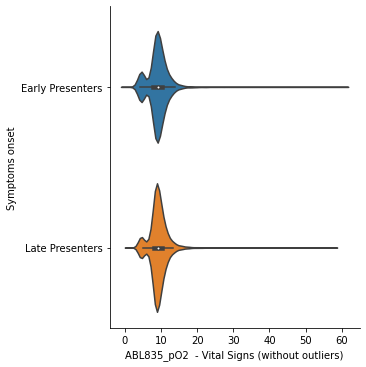

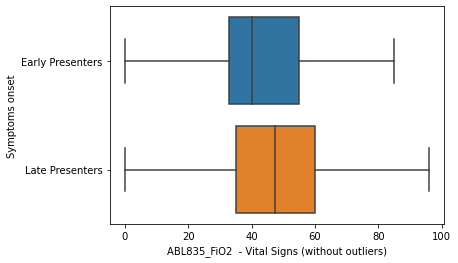

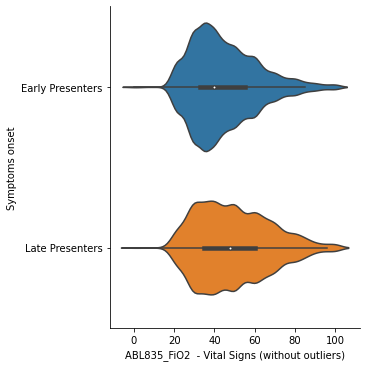

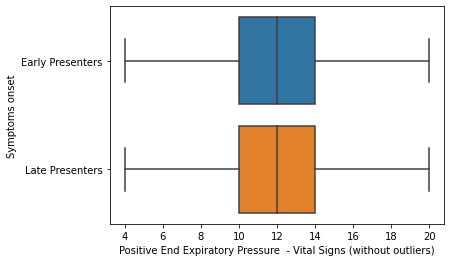

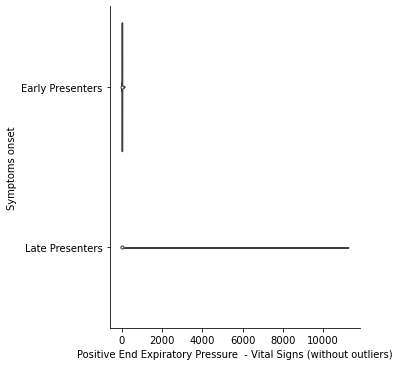

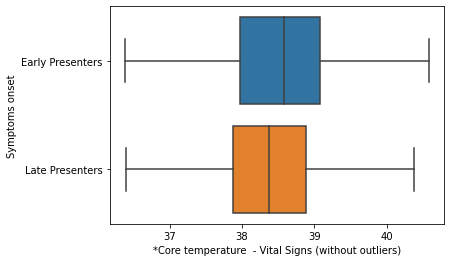

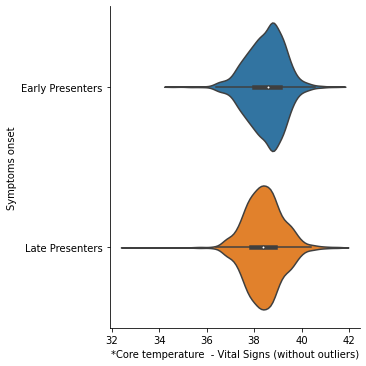

In [163]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
# vitalParamName
# vitalParamsLst = ['*Heart rate']
print("====================================================")
for vitalParamName in vitalParamsLst:
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    # print("====================================================")
    # print(vitalParamName)
    # print("====================================================")
    # print(dfAlt['UNITFROM_DATETIME'].iloc[0])
    sns.boxplot(data=dfAlt, y='Symptoms onset',x="VALUE",sym='')
    plt.xlabel(f"{vitalParamName}  - Vital Signs (without outliers)")
    plt.show()
    # print("------------------------------------------------------")
    sns.catplot(y='Symptoms onset',x="VALUE",  kind = "violin", split = True,data=dfAlt,sym='')
    plt.xlabel(f"{vitalParamName}  - Vital Signs (without outliers)")
    plt.show()


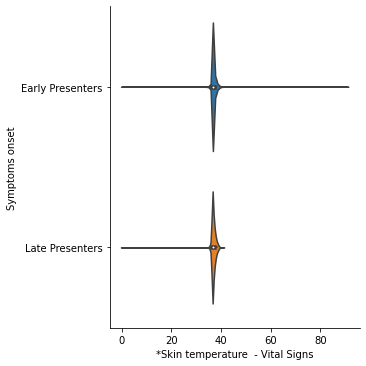

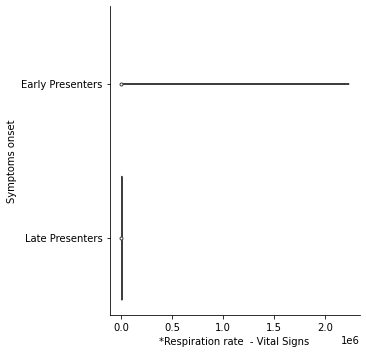

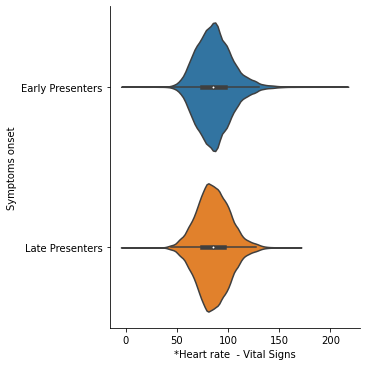

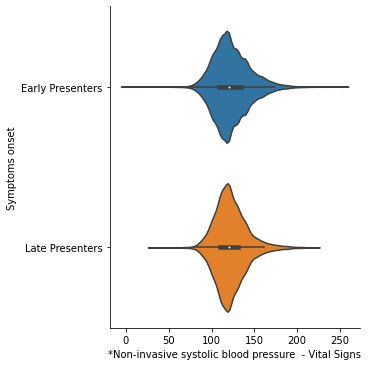

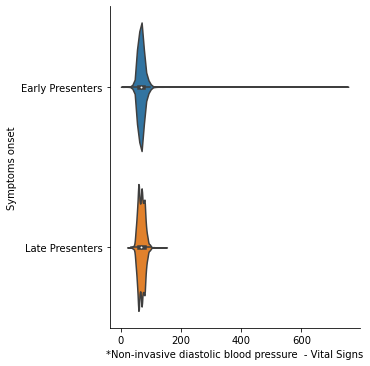

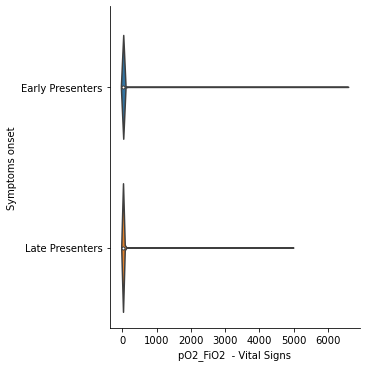

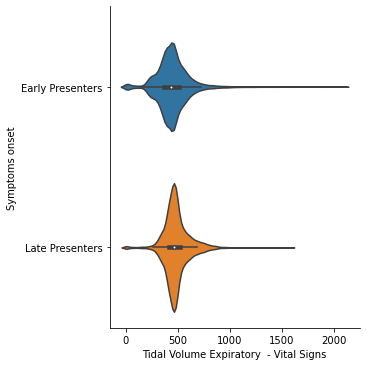

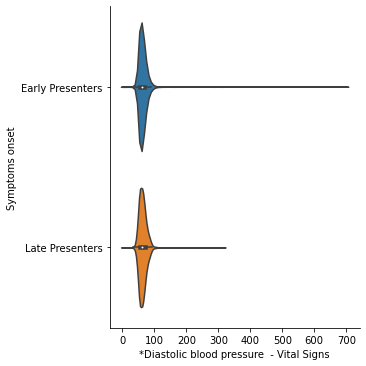

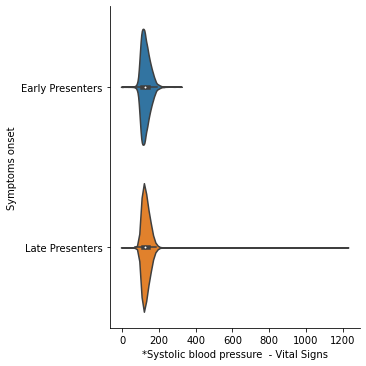

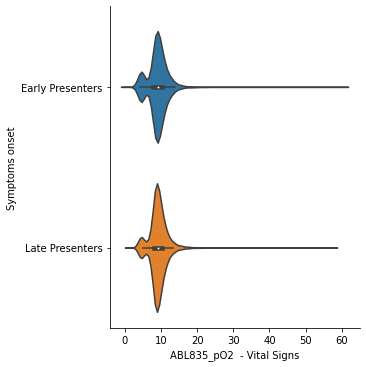

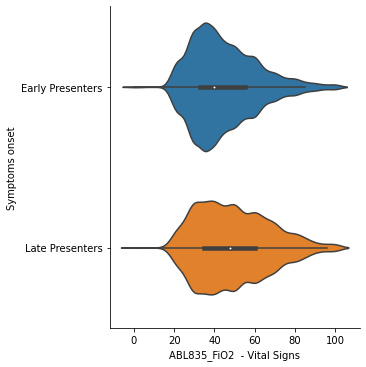

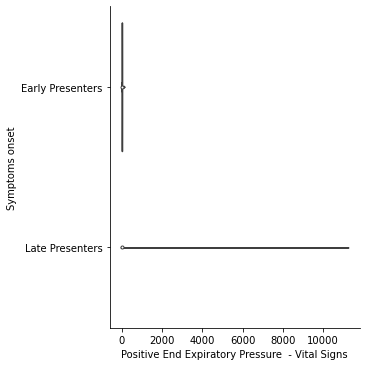

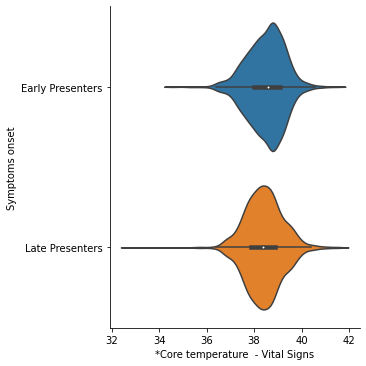

In [164]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
# vitalParamName
# vitalParamsLst = ['*Heart rate']
print("====================================================")
for vitalParamName in vitalParamsLst:
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    # print("====================================================")
    # print(vitalParamName)
    # print("====================================================")
    # print(dfAlt['UNITFROM_DATETIME'].iloc[0])
    # sns.boxplot(data=dfAlt, y='Symptoms onset',x="VALUE")
    # plt.xlabel(f"{vitalParamName}  - Vital Signs")
    # plt.show()
    # print("------------------------------------------------------")
    sns.catplot(y='Symptoms onset',x="VALUE",  kind = "violin", split = True,data=dfAlt)
    plt.xlabel(f"{vitalParamName}  - Vital Signs")
    plt.show()
    # sns.catplot(y='Symptoms onset',x="VALUE", aspect=.9,kind="swarm", data=dfAlt)
    # plt.xlabel(f"{vitalParamName}  - Vital Signs")
    # plt.show()
    # sns.distplot(dfAlt, x="VALUE", hue='Symptoms onset', element="step")

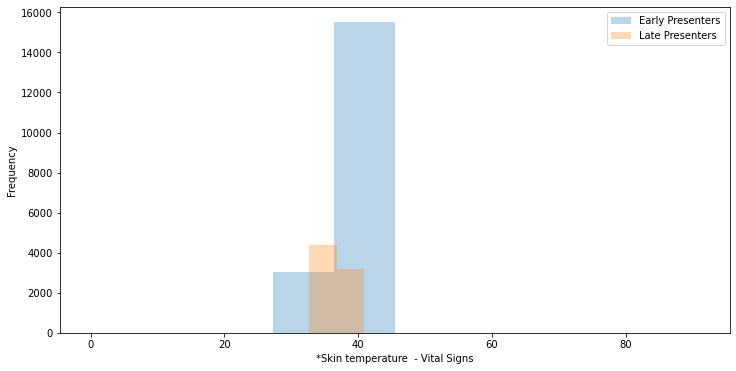

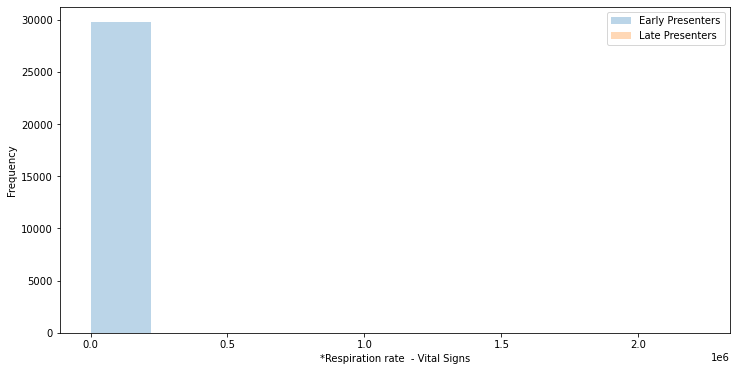

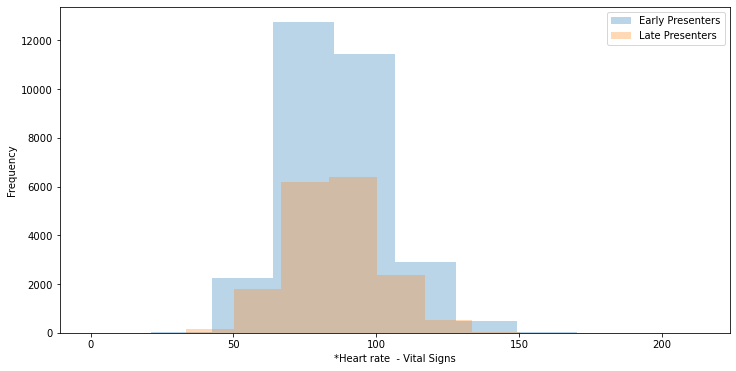

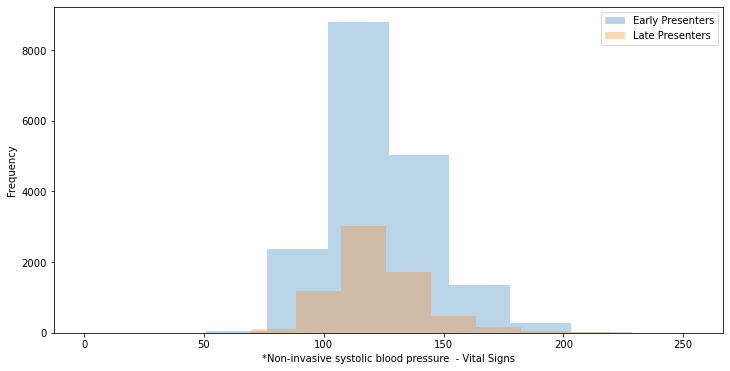

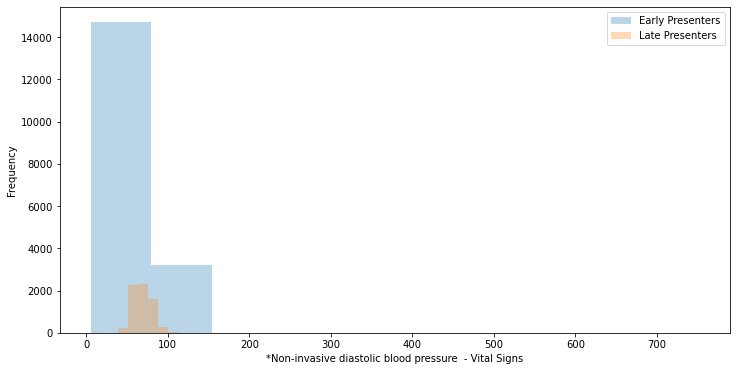

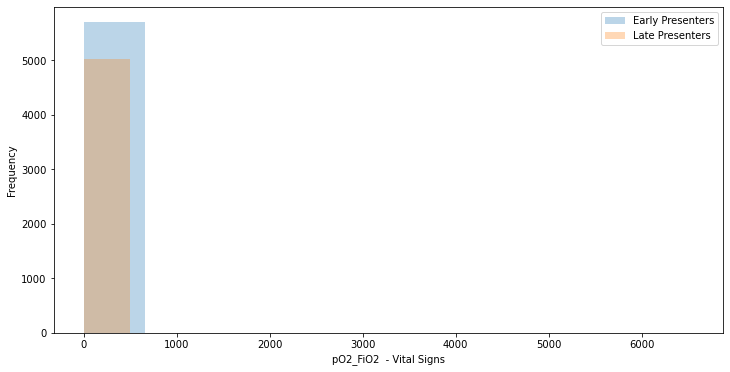

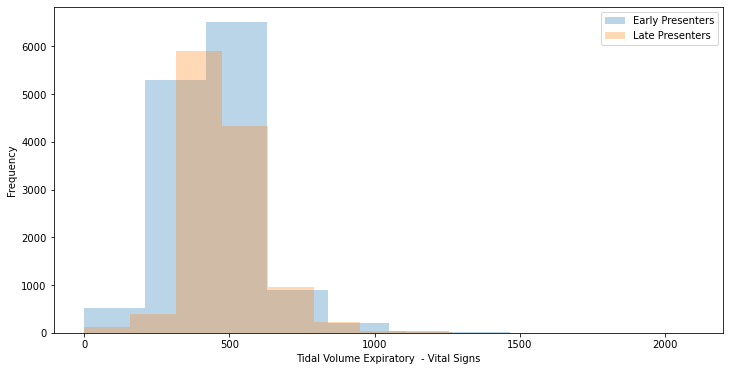

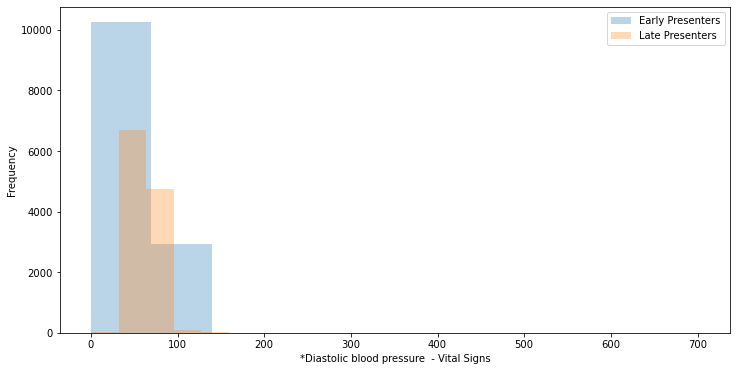

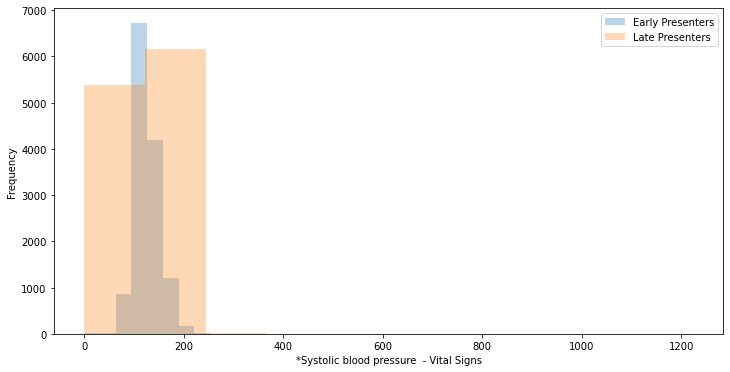

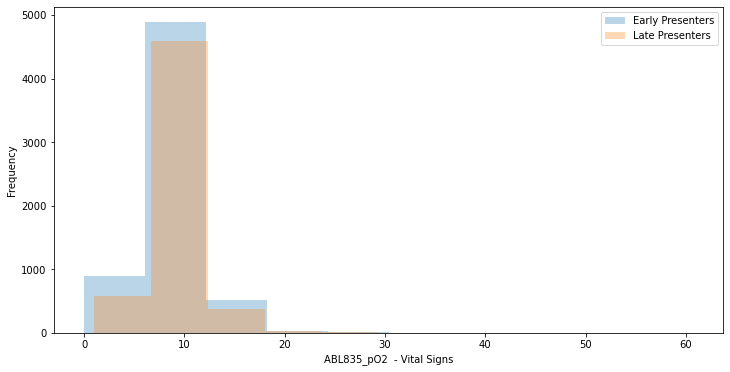

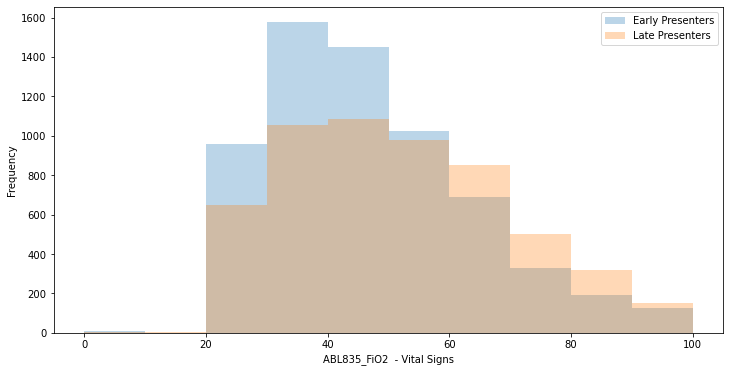

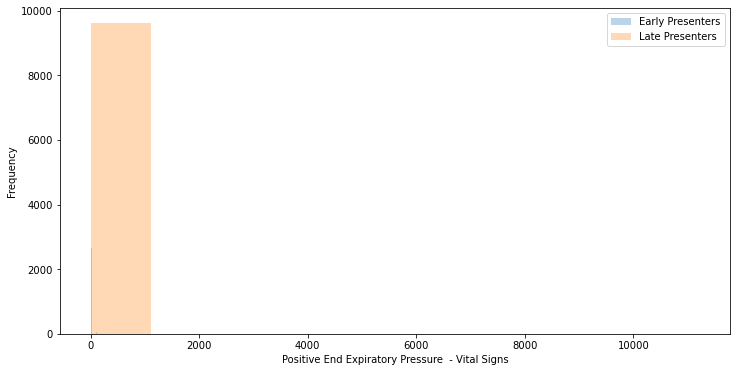

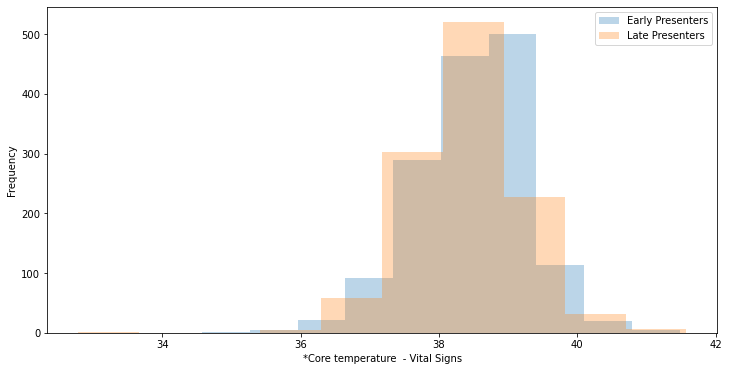

In [165]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
# vitalParamName
# vitalParamsLst = ['*Heart rate']
print("====================================================")
for vitalParamName in vitalParamsLst:
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    grp3 = dfAlt.groupby('Symptoms onset')['VALUE']
    fig, ax = grp3.plot(kind='hist', figsize=[12,6], alpha=.3, legend=True)
    ax.set(xlabel=f"{vitalParamName}  - Vital Signs", ylabel='Frequency')
    plt.show()

plt.show()

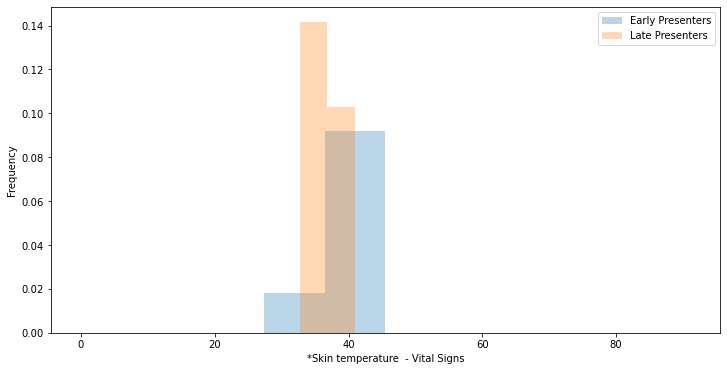

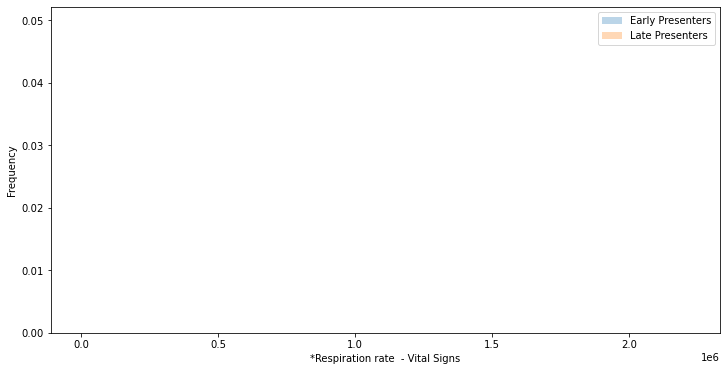

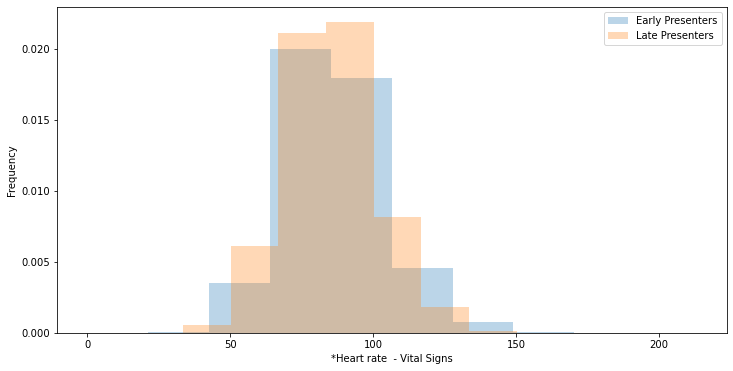

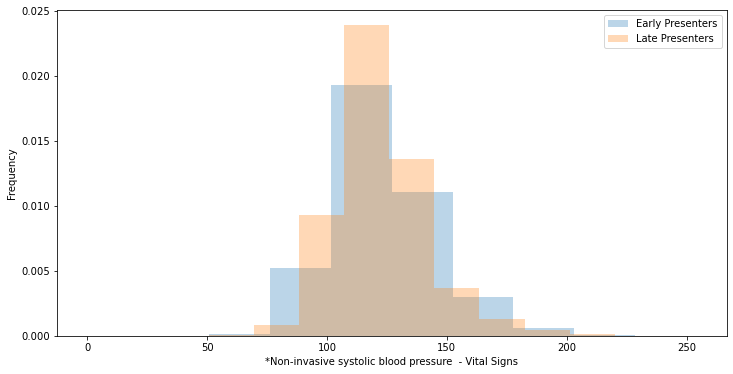

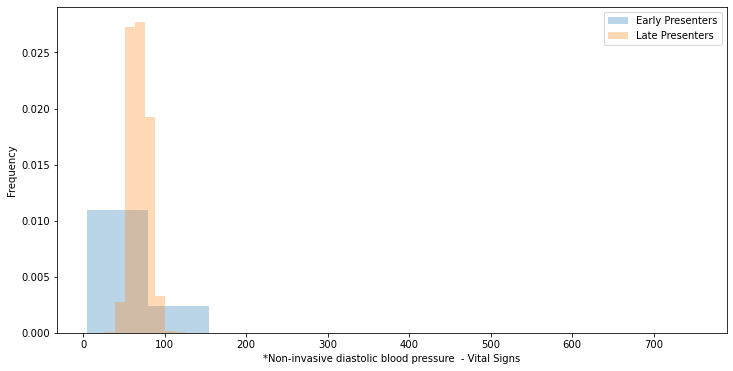

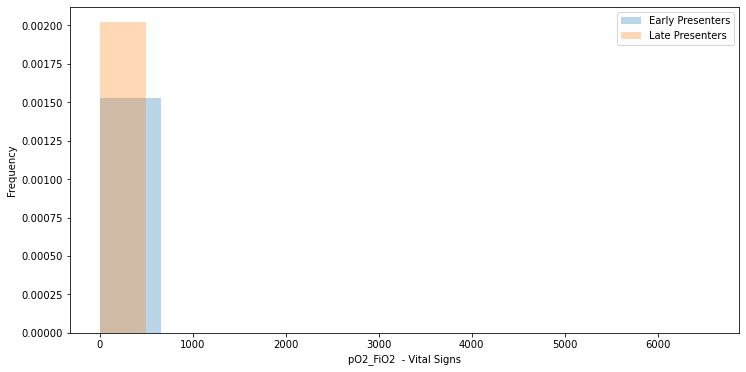

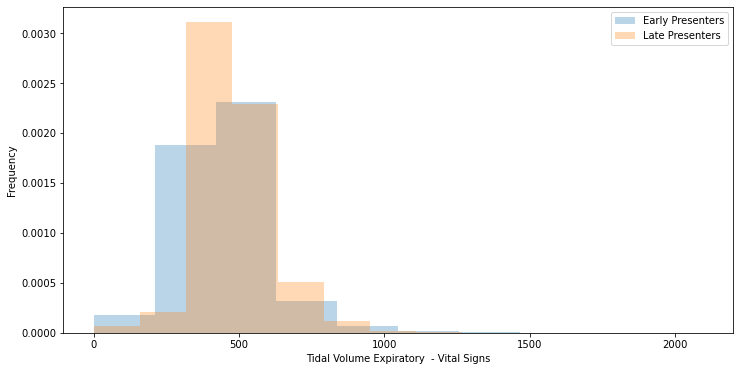

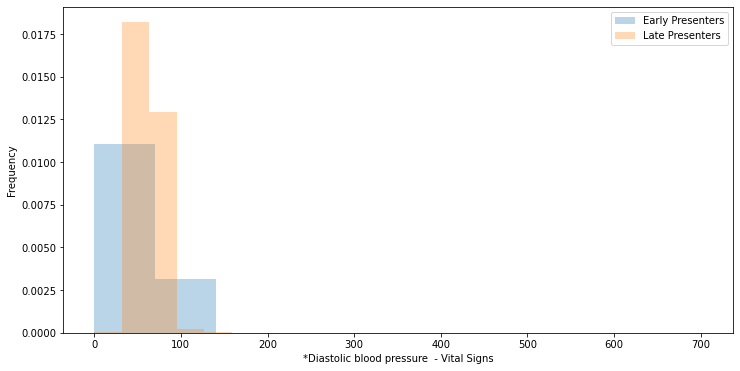

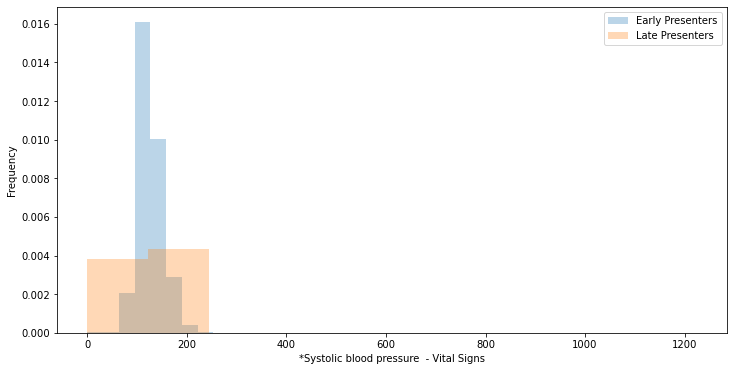

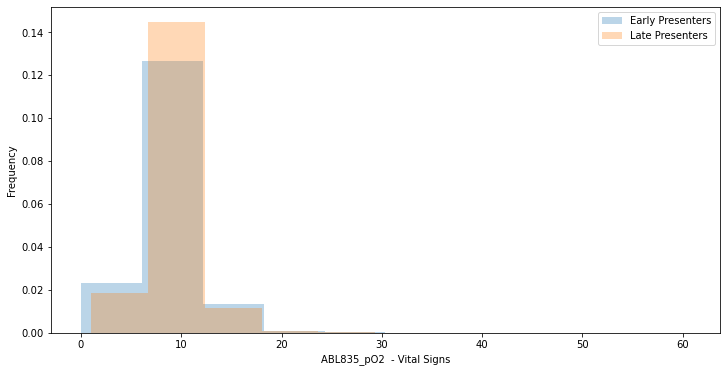

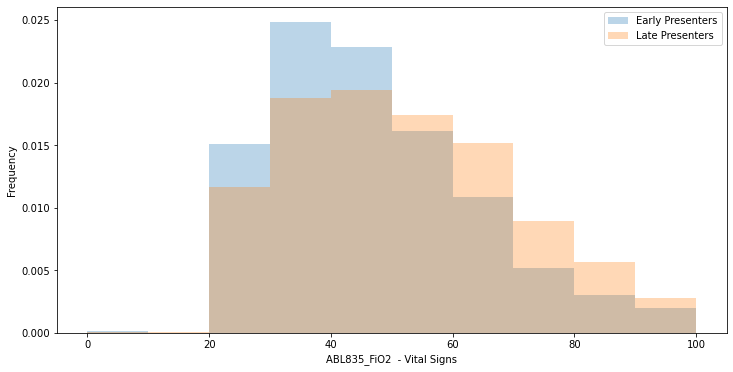

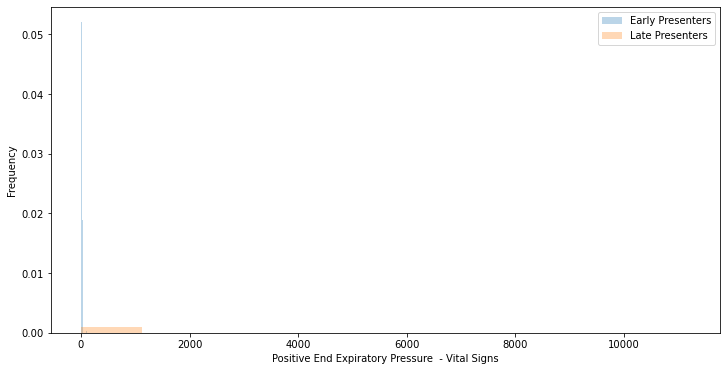

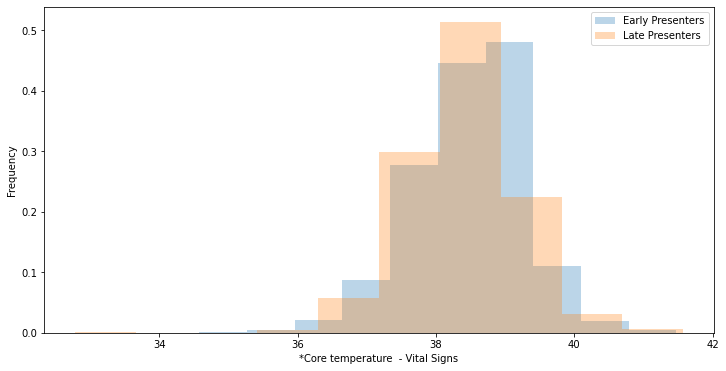

In [166]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
# vitalParamName
# vitalParamsLst = ['*Heart rate']
print("====================================================")
for vitalParamName in vitalParamsLst:
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    grp3 = dfAlt.groupby('Symptoms onset')['VALUE']
    fig, ax = grp3.plot(kind='hist', figsize=[12,6], alpha=.3, legend=True,density=True)
    ax.set(xlabel=f"{vitalParamName}  - Vital Signs", ylabel='Frequency')
    plt.show()

plt.show()

In [ ]:
timeStampStr = datetime.today().strftime("%y-%m-%d_%H-%M-%S.%f")
print("====================================================")
for vitalParamName in vitalParamsLst:
    mapLabR = dfVitalSWoHospitalUnknown['PARAMETER']== vitalParamName
    dfAlt = dfVitalSWoHospitalUnknown[mapLabR]
    # sns.distplot(dfAlt, x="VALUE", hue='Symptoms onset', element="step")
    sns.catplot(y='Symptoms onset',x="VALUE", aspect=.9,kind="swarm", data=dfAlt)
    plt.xlabel(f"{vitalParamName}  - Vital Signs")
    plt.show()

In [ ]:
# dfLabAllSelNoUnknownHospitals = dfLabAllSel.drop(dfLabAllSel[(dfLabAllSel['Symptoms onset']=="Unknown") |
#                                                        (dfLabAllSel['Symptoms onset']== "Hospital Equired") ].index)

#### Loop - Boxplots Live Signs


